In [1]:
import sys
sys.path.append("../../src")
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch.nn.functional as F

import glob
import os
from datetime import datetime
import time
import math
from tqdm import tqdm

from itertools import repeat
from torch.nn.parameter import Parameter
import collections
import matplotlib
from torch_utils import *
from ContrastiveModels import ContrastiveCorInfoMaxHopfield
from visualization import *
# matplotlib.use('Agg')

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), 
                                            torchvision.transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), 
                                            std=(3*0.2023, 3*0.1994, 3*0.2010))])

cifar_dset_train = torchvision.datasets.CIFAR10('../../data', train=True, transform=transform, target_transform=None, download=True)
train_loader = torch.utils.data.DataLoader(cifar_dset_train, batch_size=20, shuffle=True, num_workers=0)

cifar_dset_test = torchvision.datasets.CIFAR10('../../data', train=False, transform=transform, target_transform=None, download=True)
test_loader = torch.utils.data.DataLoader(cifar_dset_test, batch_size=20, shuffle=False, num_workers=0)

Files already downloaded and verified
Files already downloaded and verified


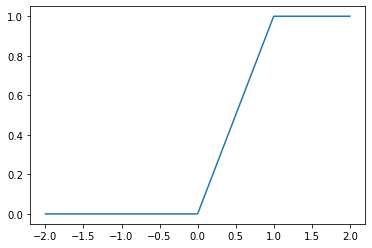

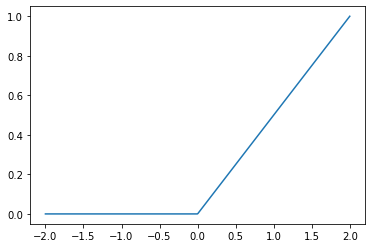

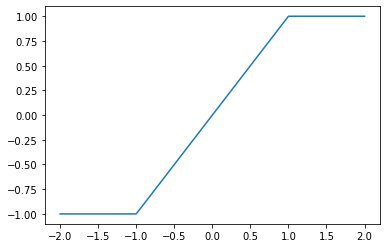

In [4]:
x = torch.linspace(-2, 2, 500)
hard_sig_output = hard_sigmoid(x)
my_hard_sig_output = my_hard_sig(x)
my_output = torch.clip(x, -1, 1)
plt.plot(torch2numpy(x), torch2numpy(hard_sig_output))
plt.show()
plt.plot(torch2numpy(x), torch2numpy(my_hard_sig_output))
plt.show()
plt.plot(torch2numpy(x), torch2numpy(my_output))
plt.show()

In [5]:
def my_activation(x):
    return torch.clip(x, -1, 1)

In [6]:
activation = my_activation
# architecture = [int(32*32*3), 500, 10]
architecture = [int(32*32*3), 1000, 1000, 1000, 10]

x,y = next(iter(train_loader))
x = x.view(x.size(0),-1).to(device).T
y_one_hot = F.one_hot(y, 10).to(device).T

beta = 0.5
lambda_ = 0.99999
epsilon = 0.15
one_over_epsilon = 1 / epsilon
# lr_start = {'ff': np.array([0.2, 0.12, 0.065, 0.035]), 'fb': np.array([ np.nan, 0.085, 0.065, 0.03])}
lr_start = {'ff': np.array([0.25 , 0.14 , 0.075, 0.045]), 'fb': np.array([  np.nan, 0.095, 0.075, 0.04 ])}
neural_lr_start = 0.03
neural_lr_stop = 0.001
neural_lr_rule = "constant"
neural_lr_decay_multiplier = 0.01
neural_dynamic_iterations_nudged = 15
neural_dynamic_iterations_free = 80
hopfield_g = 0.1
use_random_sign_beta = True
use_three_phase = False
weight_decay = False

model = ContrastiveCorInfoMaxHopfield(architecture = architecture, lambda_ = lambda_, 
                                      epsilon = epsilon, activation = activation)

In [7]:
_ = evaluateContrastiveCorInfoMaxHopfield(model, train_loader, hopfield_g,
                                          neural_lr_start, neural_lr_stop, neural_lr_rule, 
                                          neural_lr_decay_multiplier, neural_dynamic_iterations_free, device)

Train accuracy :	 0.12798


In [ ]:
trn_acc_list = []
tst_acc_list = []

n_epochs = 25

for epoch_ in range(n_epochs):
    if epoch_ < 5:
        lr = {'ff' : lr_start['ff'] * (0.9)**epoch_, 'fb' : lr_start['fb'] * (0.9)**epoch_}
    else:
        lr = {'ff' : lr_start['ff'] * (0.9)**epoch_, 'fb' : lr_start['fb'] * (0.9)**epoch_}
    for idx, (x, y) in tqdm(enumerate(train_loader)):
        x, y = x.to(device), y.to(device)
        x = x.view(x.size(0),-1).T
        y_one_hot = F.one_hot(y, 10).to(device).T
        take_debug_logs_ = (idx % 500 == 0)
        if use_random_sign_beta:
            rnd_sgn = 2*np.random.randint(2) - 1
            beta = rnd_sgn*beta
            
        neurons = model.batch_step_hopfield( x, y_one_hot, hopfield_g, 
                                             lr, neural_lr_start, neural_lr_stop, neural_lr_rule, 
                                             neural_lr_decay_multiplier, neural_dynamic_iterations_free,
                                             neural_dynamic_iterations_nudged, beta, 
                                             use_three_phase, take_debug_logs_, weight_decay)
    
    trn_acc = evaluateContrastiveCorInfoMaxHopfield(model, train_loader, hopfield_g, neural_lr_start, 
                                                    neural_lr_stop, neural_lr_rule, 
                                                    neural_lr_decay_multiplier, 
                                                    neural_dynamic_iterations_free, 
                                                    device, printing = False)
    tst_acc = evaluateContrastiveCorInfoMaxHopfield(model, test_loader, hopfield_g, neural_lr_start, 
                                                    neural_lr_stop, neural_lr_rule, 
                                                    neural_lr_decay_multiplier, 
                                                    neural_dynamic_iterations_free, 
                                                    device, printing = False)
    trn_acc_list.append(trn_acc)
    tst_acc_list.append(tst_acc)
    
    print("Epoch : {}, Train Accuracy : {}, Test Accuracy : {}".format(epoch_+1, trn_acc, tst_acc))

2500it [03:43, 11.18it/s]
0it [00:00, ?it/s]

Epoch : 1, Train Accuracy : 0.35212, Test Accuracy : 0.3512


2500it [03:43, 11.20it/s]
0it [00:00, ?it/s]

Epoch : 2, Train Accuracy : 0.38076, Test Accuracy : 0.3763


2500it [03:43, 11.18it/s]
0it [00:00, ?it/s]

Epoch : 3, Train Accuracy : 0.40124, Test Accuracy : 0.3877


2500it [03:43, 11.19it/s]
0it [00:00, ?it/s]

Epoch : 4, Train Accuracy : 0.41404, Test Accuracy : 0.4016


2500it [03:43, 11.21it/s]
0it [00:00, ?it/s]

Epoch : 5, Train Accuracy : 0.42392, Test Accuracy : 0.411


2500it [03:43, 11.20it/s]
0it [00:00, ?it/s]

Epoch : 6, Train Accuracy : 0.43582, Test Accuracy : 0.4215


2500it [03:43, 11.17it/s]
0it [00:00, ?it/s]

Epoch : 7, Train Accuracy : 0.27182, Test Accuracy : 0.2657


2500it [03:42, 11.21it/s]
0it [00:00, ?it/s]

Epoch : 8, Train Accuracy : 0.11692, Test Accuracy : 0.1185


2500it [03:42, 11.24it/s]
0it [00:00, ?it/s]

Epoch : 9, Train Accuracy : 0.1301, Test Accuracy : 0.1309


2500it [03:42, 11.22it/s]
0it [00:00, ?it/s]

Epoch : 10, Train Accuracy : 0.1128, Test Accuracy : 0.1116


2500it [03:42, 11.24it/s]
0it [00:00, ?it/s]

Epoch : 11, Train Accuracy : 0.1495, Test Accuracy : 0.1502


2500it [03:43, 11.19it/s]
0it [00:00, ?it/s]

Epoch : 12, Train Accuracy : 0.14968, Test Accuracy : 0.1498


2500it [03:43, 11.20it/s]
0it [00:00, ?it/s]

Epoch : 13, Train Accuracy : 0.11072, Test Accuracy : 0.1146


2500it [03:43, 11.20it/s]
0it [00:00, ?it/s]

Epoch : 14, Train Accuracy : 0.13052, Test Accuracy : 0.1302


2500it [03:43, 11.21it/s]
0it [00:00, ?it/s]

Epoch : 15, Train Accuracy : 0.11414, Test Accuracy : 0.1145


2500it [03:45, 11.07it/s]
0it [00:00, ?it/s]

Epoch : 16, Train Accuracy : 0.09682, Test Accuracy : 0.1021


2500it [03:43, 11.21it/s]
0it [00:00, ?it/s]

Epoch : 17, Train Accuracy : 0.11738, Test Accuracy : 0.116


2500it [03:43, 11.17it/s]
0it [00:00, ?it/s]

Epoch : 18, Train Accuracy : 0.12076, Test Accuracy : 0.1207


2500it [03:42, 11.24it/s]
0it [00:00, ?it/s]

Epoch : 19, Train Accuracy : 0.13814, Test Accuracy : 0.1361


2500it [03:42, 11.22it/s]
0it [00:00, ?it/s]

Epoch : 20, Train Accuracy : 0.12544, Test Accuracy : 0.1208


2500it [03:42, 11.22it/s]
0it [00:00, ?it/s]

Epoch : 21, Train Accuracy : 0.14362, Test Accuracy : 0.1403


2500it [03:42, 11.21it/s]
0it [00:00, ?it/s]

Epoch : 22, Train Accuracy : 0.1496, Test Accuracy : 0.1442


1709it [02:33, 11.75it/s]

In [ ]:
n_epochs = 10

for epoch_ in range(10, n_epochs + 10):
    if epoch_ < 15:
        lr = {'ff' : lr_start['ff'] * (0.9)**epoch_, 'fb' : lr_start['fb'] * (0.9)**epoch_}
    else:
        lr = {'ff' : lr_start['ff'] * (0.9)**epoch_, 'fb' : lr_start['fb'] * (0.9)**epoch_}
    for idx, (x, y) in tqdm(enumerate(train_loader)):
        x, y = x.to(device), y.to(device)
        x = x.view(x.size(0),-1).T
        y_one_hot = F.one_hot(y, 10).to(device).T
        take_debug_logs_ = (idx % 500 == 0)
        if use_random_sign_beta:
            rnd_sgn = 2*np.random.randint(2) - 1
            beta = rnd_sgn*beta
            
        neurons = model.batch_step_hopfield( x, y_one_hot, hopfield_g, 
                                             lr, neural_lr_start, neural_lr_stop, neural_lr_rule, 
                                             neural_lr_decay_multiplier, neural_dynamic_iterations_free,
                                             neural_dynamic_iterations_nudged, beta, 
                                             use_three_phase, take_debug_logs_, weight_decay)
    
    trn_acc = evaluateContrastiveCorInfoMaxHopfield(model, train_loader, hopfield_g, neural_lr_start, 
                                                    neural_lr_stop, neural_lr_rule, 
                                                    neural_lr_decay_multiplier, 
                                                    neural_dynamic_iterations_free, 
                                                    device, printing = False)
    tst_acc = evaluateContrastiveCorInfoMaxHopfield(model, test_loader, hopfield_g, neural_lr_start, 
                                                    neural_lr_stop, neural_lr_rule, 
                                                    neural_lr_decay_multiplier, 
                                                    neural_dynamic_iterations_free, 
                                                    device, printing = False)
    trn_acc_list.append(trn_acc)
    tst_acc_list.append(tst_acc)
    
    print("Epoch : {}, Train Accuracy : {}, Test Accuracy : {}".format(epoch_+1, trn_acc, tst_acc))

In [ ]:
plot_convergence_plot(trn_acc_list, xlabel = 'Number of Epochs', ylabel = 'Accuracy %',
                      title = 'Contrastive CorInfoMax Train Accuracy w.r.t. Epochs', 
                      figsize = (12,8), fontsize = 25, linewidth = 3)

In [ ]:
plot_convergence_plot(tst_acc_list, xlabel = 'Number of Epochs', ylabel = 'Accuracy %',
                      title = 'Contrastive CorInfoMax Test Accuracy w.r.t. Epochs', 
                      figsize = (12,8), fontsize = 25, linewidth = 3)